# Lightweight Fine-Tuning Project

Below I list the PEFT technique, the model, evaluation approach and fine-tunning dataset I'll be using to fine tune the LLM
* PEFT technique: LoRA
* Model: Llama 3.1 8B
* Evaluation approach: Hugging Face Trainer.evaluate
* Fine-tuning dataset: [AuthorMix](https://huggingface.co/datasets/hallisky/AuthorMix)

## Loading and Evaluating a Foundation Model

Loading Llama 3.1 8B model and evaluate its performance prior to fine-tuning. This includes loading an appropriate tokenizer and dataset.

## Load in IMDB Dataset

In [ ]:
# Install dependencies
!pip install -q "datasets>=2.16.1"
!pip install torch
!pip install transformers
!pip install python-dotenv
!pip install peft

In [1]:
from datasets import load_dataset

# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(1000))

# Show the dataset
ds

{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 })}

### Dataset Exploration

In [2]:
import pandas as pd

train_df = pd.DataFrame(ds['train'])

print(train_df.head())

       style                                               text category
0  blog11518  "Jamaia....come and help me talk some sense in...     blog
1  blog25872  I decided I wasn't going to go to Boler today....     blog
2      obama  For over two decades, bin Laden has been al Qa...   speech
3  blog11518  motion with precise timing. Sucking the cigare...     blog
4  blog11518  "So what, we just stand here?" Alyx prompts, h...     blog


The dataset contains 14 unique authors

In [3]:
unique_styles = train_df['style'].unique()
print(unique_styles)

['blog11518' 'blog25872' 'obama' 'fitzgerald' 'hemingway' 'woolf' 'bush'
 'blog30102' 'blog5546' 'trump' 'blog30407' 'qq' 'pp' 'h']


In 4 number of formats/categories

In [4]:
unique_formats = train_df['category'].unique()
print(unique_formats)

['blog' 'speech' 'author' 'amt']


Dataset sample text length just skew towards 335 characters or less 

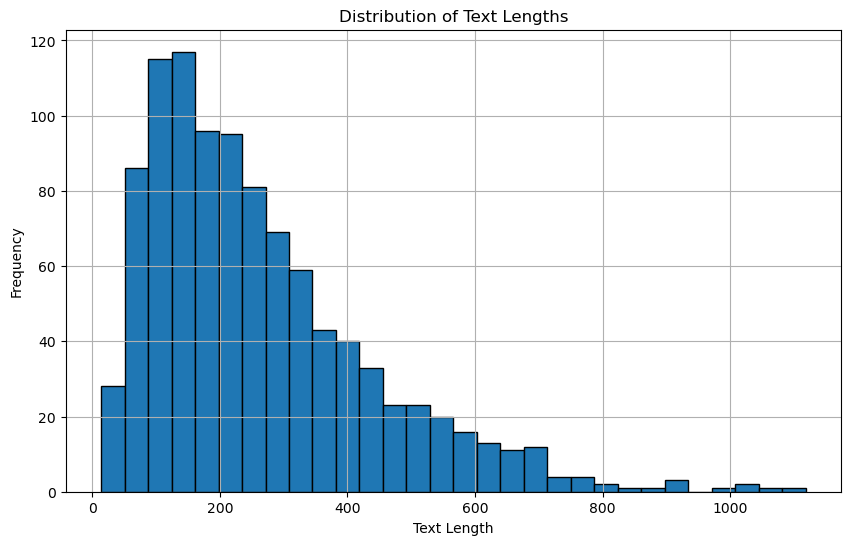

In [5]:
import matplotlib.pyplot as plt

train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Intial Llama 3.1 8B/GPT-2 evaluation on the dataset
Going to load in the Llama/GPT-2 model through AutoModelForSequenceClassification and set the label ids

In [6]:
import torch
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv("env.txt")
hf_token = os.getenv('HF_API_TOKEN')
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

num_labels = len(unique_styles)
id2label = {i: style for i, style in enumerate(unique_styles)}
label2id = {v: k for k, v in id2label.items()}
print(f"num_labels: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")
llama_model_key = "meta-llama/Meta-Llama-3.1-8B"
gpt_model_key = "openai-community/gpt2"
gpt_model = AutoModelForSequenceClassification.from_pretrained(
    gpt_model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    token=True,
)
llama_model = gpt_model = AutoModelForSequenceClassification.from_pretrained(
    llama_model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    token=True,
)

num_labels: 14
id2label: {0: 'blog11518', 1: 'blog25872', 2: 'obama', 3: 'fitzgerald', 4: 'hemingway', 5: 'woolf', 6: 'bush', 7: 'blog30102', 8: 'blog5546', 9: 'trump', 10: 'blog30407', 11: 'qq', 12: 'pp', 13: 'h'}
label2id: {'blog11518': 0, 'blog25872': 1, 'obama': 2, 'fitzgerald': 3, 'hemingway': 4, 'woolf': 5, 'bush': 6, 'blog30102': 7, 'blog5546': 8, 'trump': 9, 'blog30407': 10, 'qq': 11, 'pp': 12, 'h': 13}


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Tokenizer setup
# GPT
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_key, token=True)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
#llama
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_key, token=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
def get_prediction(text, model, tokenizer):

    # Tokenize the text
    # (Get the response as tensors and not as a list)
    inputs = tokenizer(text, return_tensors="pt")

    # Perform the prediction (get the logits)
    outputs = model(**inputs)

    # Get the logits
    logits = outputs.logits
    
    # Apply softmax to the logits to get probabilities
    probabilities = torch.softmax(logits, dim=-1)
    
    # Get the predicted class (corresponding to the highest logit)
    predicted_class = torch.argmax(logits, dim=-1)
    
    return predicted_class, probabilities

In [21]:
ds['test'][15]

{'style': 'woolf',
 'text': '"It\'s his way of making friends, I suppose," she laughed. "Well--I shall do my part. I shall begin--\'Ugly in body, repulsive in mind as you are, Mr. Hirst--\'"',
 'category': 'author'}

In [29]:
prediction = get_prediction(ds['test'][15]['text'], llama_model, llama_tokenizer)
prediction

(tensor([7]),
 tensor([[3.6282e-03, 2.8605e-05, 4.9584e-06, 1.0194e-06, 2.3843e-03, 3.9152e-04,
          8.7304e-04, 9.8857e-01, 2.6047e-03, 1.4705e-03, 4.7815e-05]],
        grad_fn=<SoftmaxBackward0>))

In [10]:
import time

def evaluate_model(dataset, model, tokenizer, n=None):
    correct_predictions = 0
    total_predictions = 0

    # If n is None, evaluate the whole dataset
    n = len(dataset['test']) if n is None else n

    start_time = time.time()
    
    # Loop over the dataset up to n rows
    for i in range(n):
        # Get the input text and true label from the dataset
        text = dataset['test'][i]['text']
        true_label = dataset['test'][i]['style']  # Assuming 'style' is the label field
        
        # Get the model's prediction and probabilities
        predicted_class, _ = get_prediction(text, model, tokenizer)
        
        # Check if the prediction is correct
        if predicted_class.item() == label2id[true_label]:  # Convert tensor to scalar with .item()
            correct_predictions += 1
        
        total_predictions += 1

    end_time = time.time()
    time_taken = end_time - start_time
    
    # Calculate the accuracy
    accuracy = correct_predictions / total_predictions * 100
    print(f"Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_predictions})")
    print(f"Time taken: {time_taken:.2f} seconds for {n} samples")

    
    return accuracy

### Llama Pre-Training Accuracy

In [11]:
evaluate_model(ds, model=llama_model, tokenizer=llama_tokenizer, n=10)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Accuracy: 0.00% (0/10)
Time taken: 284.47 seconds for 10 samples


0.0

### GPT Pre-Training Accuracy

In [12]:
evaluate_model(ds, model=gpt_model, tokenizer=gpt_tokenizer, n=10)

Accuracy: 0.00% (0/10)
Time taken: 280.59 seconds for 10 samples


0.0

### Setup PEFT Models

In [9]:
from peft import get_peft_model, LoraConfig, TaskType

# Set up LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

gpt_model = get_peft_model(gpt_model, lora_config)
llama_model = get_peft_model(llama_model, lora_config)

### Preprocess dataset

In [16]:
from datasets import DatasetDict
from functools import partial


# Preprocessing function
def preprocess_function(examples, tokenizer):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=1600) #longest character count in dataset is about 1,550 characters, hints the max length
    # tokens['label'] = [label2id.get(style, -1) for style in examples['style']]
    # return tokens

gpt_2_tokenize = partial(preprocess_function, tokenizer=gpt_tokenizer)
llama_tokenize = partial(preprocess_function, tokenizer=llama_tokenizer)

def tokenize_splits(model_tokenizer):
    tokenized_datasets = {}
    for split in ds.keys():
        # Tokenize the split
        tokenized_split = ds[split].map(model_tokenizer, batched=True)
        
        # Rename the 'label' column to 'labels'
        tokenized_split = tokenized_split.rename_column("style", "labels")
        
        # Set the format of the dataset to PyTorch tensors
        tokenized_split.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        
        # Store the processed split
        tokenized_datasets[split] = tokenized_split

    return tokenized_datasets
        
gpt_2_tokenized_ds = tokenize_splits(gpt_2_tokenize)
llama_tokenized_ds = tokenize_splits(llama_tokenize)
print(f"gpt_2_tokenized_ds: {gpt_2_tokenized_ds}")
print(f"llama_tokenized_ds: {llama_tokenized_ds}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

gpt_2_tokenized_ds: {'train': Dataset({
    features: ['labels', 'text', 'category', 'input_ids', 'attention_mask'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['labels', 'text', 'category', 'input_ids', 'attention_mask'],
    num_rows: 1000
})}
llama_tokenized_ds: {'train': Dataset({
    features: ['labels', 'text', 'category', 'input_ids', 'attention_mask'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['labels', 'text', 'category', 'input_ids', 'attention_mask'],
    num_rows: 1000
})}


## Setup Training

In [17]:
from transformers import (
    TrainingArguments,
    Trainer
)
from datasets import load_metric


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)

# Define metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }


##setup validation for datasets
def create_validation_split(dataset):
    dataset["train"] = dataset["train"].train_test_split(test_size=0.1)
    dataset["validation"] = dataset["train"]["test"]
    dataset["train"] = dataset["train"]["train"]
    return dataset

gpt_2_tokenized_ds = create_validation_split(gpt_2_tokenized_ds)
gpt_trainer = Trainer(
    model=gpt_model,
    args=training_args,
    train_dataset=gpt_2_tokenized_ds["train"],
    eval_dataset=gpt_2_tokenized_ds["validation"],
    compute_metrics=compute_metrics
)

llama_tokenized_ds = create_validation_split(llama_tokenized_ds)
llama_trainer = Trainer(
    model=llama_model,
    args=training_args,
    train_dataset=llama_tokenized_ds["train"],
    eval_dataset=llama_tokenized_ds["validation"],
    compute_metrics=compute_metrics
)


/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/datasets/load.py:759: Futu

### Train GPT-2

In [18]:
gpt_trainer.train()

RuntimeError: MPS backend out of memory (MPS allocated: 45.64 GB, other allocations: 210.75 MB, max allowed: 45.90 GB). Tried to allocate 200.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).